In [1]:
import sys
import os

In [2]:
sys.path.append('..')

In [76]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score



pd.set_option('display.width', 120)

%matplotlib inline

plt.rcParams["figure.figsize"] = (24,8)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.grid'] = True 

plt.rcParams['font.family']='AppleGothic'

In [4]:
from utils.prepare_data import *
from utils.model_helper import *

/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
from custum_dataset import digi_data_load, testcase_add_data_load, testcase_shuffle_data_load
from attn_bi_lstm import ABLSTM

In [6]:
#TRAIN_DOC, TRAIN_LABEL, TEST_DOC, TEST_LABEL, cols = digi_data_load()
#TRAIN_DOC, TRAIN_LABEL, TEST_DOC, TEST_LABEL, cols = testcase_add_data_load()
TRAIN_DOC, TRAIN_LABEL, TEST_DOC, TEST_LABEL, cols = testcase_shuffle_data_load()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29769 entries, 1 to 38319
Data columns (total 4 columns):
sent          29769 non-null object
nlu_result    29769 non-null object
class         29769 non-null object
clean_text    29769 non-null object
dtypes: object(4)
memory usage: 1.1+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 28516 entries, 1 to 38319
Data columns (total 4 columns):
sent          28516 non-null object
nlu_result    28516 non-null object
class         28516 non-null object
clean_text    28516 non-null object
dtypes: object(4)
memory usage: 1.1+ MB
32760 1062


In [7]:
train_intent = np.apply_along_axis(np.argmax,1,TRAIN_LABEL)
test_intent = np.apply_along_axis(np.argmax,1,TEST_LABEL)

In [8]:
%%time
train_doc = TRAIN_DOC.tolist()
test_doc = TEST_DOC.tolist()

#train_doc = pd.Series(list(map(lambda x: ' '.join(twitter.morphs(x)), train_doc)))
#test_doc = pd.Series(list(map(lambda x: ' '.join(twitter.morphs(x)), test_doc)))
train_doc = pd.Series(list(map(lambda x: ' '.join(list(x.replace(' ','ⓢ'))), train_doc)))
test_doc = pd.Series(list(map(lambda x: ' '.join(list(x.replace(' ','ⓢ'))), test_doc)))

CPU times: user 83.4 ms, sys: 2.89 ms, total: 86.3 ms
Wall time: 84.8 ms


In [9]:
y_train = pd.Series(train_intent)
y_test = pd.Series(test_intent)

In [10]:
x_train, x_test, tokenizer = \
        data_preprocessing_v2(train_doc, test_doc, max_len=64)
vocab_size = tokenizer.num_words

In [11]:
test_size = len(x_test)

config = {
    "max_len": 64,
    "hidden_size": 64,
    "vocab_size": vocab_size,
    "embedding_size": 128,
    "n_class": 33,
    "learning_rate": 1e-3,
    "batch_size": 4,
    "train_epoch": 20
}
modelname = 'attn_bilstm_test'

In [12]:
sess = tf.Session()

classifier = ABLSTM(sess, config)
classifier.build_graph(modelname)

sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()

resume = True
if resume:
    saver.restore(sess, "./Saver/{}/{}.ckpt".format(modelname, modelname))


preds = []
probas = []
reals = []
attns = []
for x_batch, y_batch in fill_feed_dict(x_test, y_test,1062, isshuffle=False):
    pred, proba = get_prediction(classifier, sess, (x_batch, y_batch))
    attn = get_attn_weight(classifier, sess, (x_batch, y_batch),0.1)
    preds += pred.tolist()
    probas += proba.tolist()
    attns += attn.tolist()
    reals += y_batch.tolist()

building graph
graph built successfully!
INFO:tensorflow:Restoring parameters from ./Saver/attn_bilstm_test/attn_bilstm_test.ckpt


In [13]:
test_df = pd.DataFrame({'sent':test_doc,'attn':attns, 'pred':preds, 'real':reals,'proba':probas})
test_df

,sent,attn,pred,real,proba
0,다 음 에 또 할 께 요,"[0.03684328868985176, 0.17599016427993774, 0.3...",5,5,"[1.5332898328779265e-05, 3.0314209652715363e-0..."
1,그 냥 ⓢ 이 렇 게 ⓢ 끝 내 면 ⓢ 안 되 죠 . ⓢ 다 른 ⓢ 해 상 도 를 ...,"[0.007998905144631863, 0.0032018115743994713, ...",24,24,"[2.7220296033192426e-05, 5.946740770923498e-07..."
2,정 기 결 재 \ n 해 지 \ n 했 으 니 \ n \ n 환 불 ⓢ 바 랍 니 다,"[0.004420656710863113, 0.0009677381021901965, ...",28,28,"[3.641542934929021e-05, 8.256265573436394e-06,..."
3,방 송 할 만 한 노 트 북,"[0.010125713422894478, 0.6491497755050659, 0.2...",8,7,"[5.065578534413362e-06, 4.166990493104095e-06,..."
4,번 품 할 려 구 요,"[0.10127127170562744, 0.8659634590148926, 0.02...",7,7,"[0.004704352002590895, 0.0005459773237816989, ..."
5,이 용 권 ⓢ 종 료 하 려 구 요 ~ !,"[0.0003309959138277918, 0.013854616321623325, ...",4,4,"[7.068328704917803e-05, 1.326778487964475e-06,..."
6,비 밀 쿠 폰 이 뭔 가 요,"[0.0004105519037693739, 0.015339111909270287, ...",25,25,"[0.00033054989762604237, 6.753411435056478e-05..."
7,삼 쥐 ⓢ 에 어 컨 ⓢ 찾 아 줘,"[0.0008302052156068385, 0.00045368619612418115...",24,24,"[6.0105830925749615e-06, 2.123246218843633e-07..."
8,전 화 도 ⓢ 안 오 고,"[0.060545116662979126, 0.8692189455032349, 0.0...",17,17,"[1.1151265653097653e-06, 1.180993058369495e-05..."
9,비 밀 번 호 ⓢ 어 떻 게 ⓢ 바 꾸 나 요 ? ?,"[6.736804061802104e-05, 0.019759267568588257, ...",4,29,"[0.0004737282870337367, 5.218152182351332e-06,..."


In [14]:
test_df['real'] = test_df['real'].apply(lambda x: cols[x])
test_df['pred'] = test_df['pred'].apply(lambda x: cols[x])

In [15]:
f1_score(test_df['real'],test_df['pred'],average='weighted')

0.8298426025862448

In [16]:
test_df[test_df['real'] == test_df['pred']]

,sent,attn,pred,real,proba
0,다 음 에 또 할 께 요,"[0.03684328868985176, 0.17599016427993774, 0.3...",DIGITAL_P대화종료,DIGITAL_P대화종료,"[1.5332898328779265e-05, 3.0314209652715363e-0..."
1,그 냥 ⓢ 이 렇 게 ⓢ 끝 내 면 ⓢ 안 되 죠 . ⓢ 다 른 ⓢ 해 상 도 를 ...,"[0.007998905144631863, 0.0032018115743994713, ...",DIGITAL_P추천,DIGITAL_P추천,"[2.7220296033192426e-05, 5.946740770923498e-07..."
2,정 기 결 재 \ n 해 지 \ n 했 으 니 \ n \ n 환 불 ⓢ 바 랍 니 다,"[0.004420656710863113, 0.0009677381021901965, ...",DIGITAL_P환불문의,DIGITAL_P환불문의,"[3.641542934929021e-05, 8.256265573436394e-06,..."
4,번 품 할 려 구 요,"[0.10127127170562744, 0.8659634590148926, 0.02...",DIGITAL_P반품문의,DIGITAL_P반품문의,"[0.004704352002590895, 0.0005459773237816989, ..."
5,이 용 권 ⓢ 종 료 하 려 구 요 ~ !,"[0.0003309959138277918, 0.013854616321623325, ...",DIGITAL_P기타faq문의,DIGITAL_P기타faq문의,"[7.068328704917803e-05, 1.326778487964475e-06,..."
6,비 밀 쿠 폰 이 뭔 가 요,"[0.0004105519037693739, 0.015339111909270287, ...",DIGITAL_P쿠폰요청,DIGITAL_P쿠폰요청,"[0.00033054989762604237, 6.753411435056478e-05..."
7,삼 쥐 ⓢ 에 어 컨 ⓢ 찾 아 줘,"[0.0008302052156068385, 0.00045368619612418115...",DIGITAL_P추천,DIGITAL_P추천,"[6.0105830925749615e-06, 2.123246218843633e-07..."
8,전 화 도 ⓢ 안 오 고,"[0.060545116662979126, 0.8692189455032349, 0.0...",DIGITAL_P전화요청,DIGITAL_P전화요청,"[1.1151265653097653e-06, 1.180993058369495e-05..."
10,전 화 ⓢ 연 결 이 ⓢ 되 야 ⓢ 물 어 보 죠,"[0.007682702969759703, 0.5743125677108765, 0.0...",DIGITAL_P전화요청,DIGITAL_P전화요청,"[2.8390452371240826e-06, 2.9810382329742424e-0..."
12,항 공 권 ⓢ 예 약 ⓢ 취 소 는 ⓢ 어 떻 게 하 나 요 ?,"[0.001966043608263135, 0.002223322866484523, 0...",DIGITAL_P주문취소,DIGITAL_P주문취소,"[0.00017979464610107243, 7.156839274102822e-05..."


In [17]:
def add_pad(text):
    max_len = 64
    text = text.replace(' ','')
    text = text + 'ⓟ'*(64-len(text))
    return text[:64]

In [18]:
test_df['sent'] = test_df['sent'].apply(add_pad)

In [66]:
def summary_pattern(text, attn):
    # pad 삭제
    text = text.replace('ⓟ','')
    attn = attn[:len(text)]
    sum_attns = []
    sum_attn = 0
    for i, char in enumerate(text):
        if char == 'ⓢ':
            sum_attns.append(sum_attn)
            sum_attn = 0
        sum_attn += attn[i]
    sum_attns.append(sum_attn)
    
    df = pd.DataFrame({'word':text.split('ⓢ'),'sum_attn':sum_attns})
    
    df['selected'] = 0
    df = df.sort_values('sum_attn',ascending=False)

    words = []
    word_attn = 0
    for i, row in df.iterrows():
        word_attn += row['sum_attn']
        df.loc[df.word == row['word'],'selected'] = 1
        
        if word_attn > 0.95:
            return df.sort_index()
    
    return None
    # space단위 attn 합산
    # attn 합산 ordering해서 90되면 stop
    # text 리턴

DIGITAL_P주문취소 DIGITAL_P주문취소 0.8097506165504456


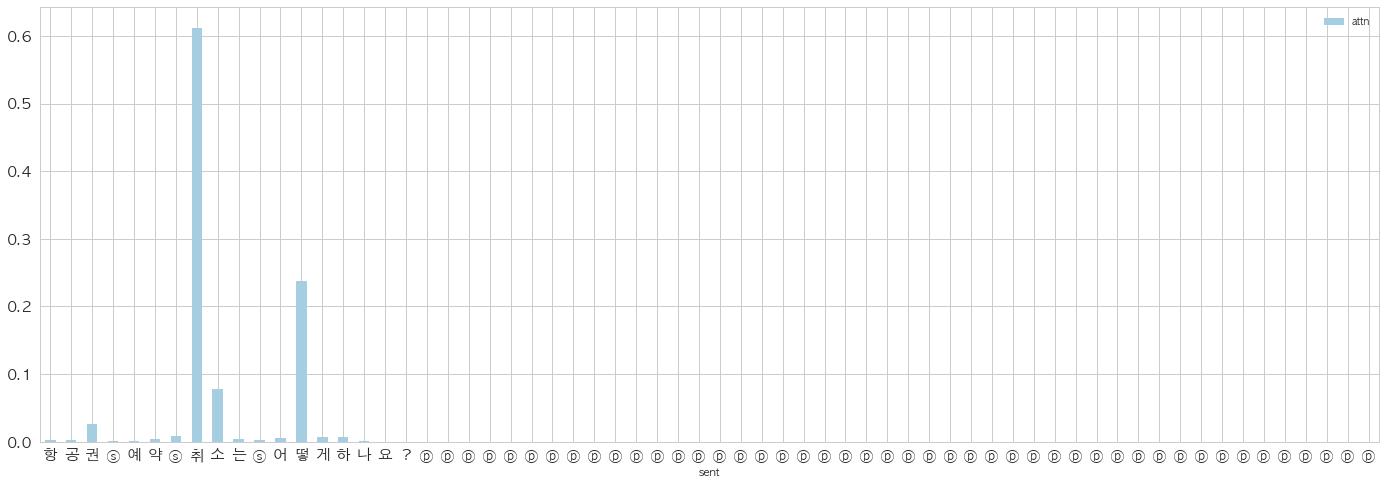

In [20]:
index = 12
row = pd.DataFrame({'sent':list(test_df['sent'][index]), 'attn':test_df['attn'][index]}) 
ax = row.plot.bar(x='sent',y='attn',rot=0,colormap='Paired',fontsize= 15)
print(test_df['real'][index], test_df['pred'][index], max(test_df['proba'][index]))

In [21]:
summary_pattern(test_df['sent'][index],test_df['attn'][index])

      word  sum_attn  selected
2      취소는  0.702269         0
3  어떻게하나요?  0.260796         0
0      항공권  0.031192         0
1       예약  0.005668         0


,word,sum_attn,selected
0,항공권,0.031192,0
1,예약,0.005668,0
2,취소는,0.702269,1
3,어떻게하나요?,0.260796,1


In [70]:
def predict(sess, model, text, cols):
    text_idx = tokenizer.texts_to_sequences([text])
    text_padded = pad_sequences(text_idx, maxlen=config['max_len'],padding='post',truncating='post')
    text_padded = np.concatenate([text_padded, text_padded])
    pred, proba, attn = sess.run([model.prediction, model.proba, model.alpha], 
                           feed_dict={model.x:text_padded,
                                      model.keep_prob:1.0})
    return cols[pred[0]], max(proba[0]), attn[0]

In [74]:
def run_test():
    print('TEST START!')
    while True:
        text = input("RAW Text를 입력하세요!\t")
        text = ' '.join(list(text.replace(' ','ⓢ')))
        speech_act, prob, attns = predict(sess, classifier, text, cols)
        text_pad = add_pad(text)
        row = pd.DataFrame({'sent':list(text_pad), 'attn':attns}) 
        ax = row.plot.bar(x='sent',y='attn',rot=0,colormap='Paired',fontsize= 15)
        print('\n',text,' -> ', speech_act,'({})'.format(prob))
        
        print(summary_pattern(text_pad,attns))
        break

In [91]:
cols

Index(['DIGITAL_Pa/s문의', 'DIGITAL_P가격문의', 'DIGITAL_P결제문의', 'DIGITAL_P교환문의', 'DIGITAL_P기타faq문의', 'DIGITAL_P대화종료',
       'DIGITAL_P도움말보기', 'DIGITAL_P반품문의', 'DIGITAL_P배송문의', 'DIGITAL_P배송일문의', 'DIGITAL_P배송지변경문의', 'DIGITAL_P본인인증문의',
       'DIGITAL_P상담시간', 'DIGITAL_P상담요청', 'DIGITAL_P상담원연결', 'DIGITAL_P상담품목', 'DIGITAL_P상품문의_P상담원연결', 'DIGITAL_P전화요청',
       'DIGITAL_P주문이력확인', 'DIGITAL_P주문취소', 'DIGITAL_P차이점', 'DIGITAL_P채팅', 'DIGITAL_P챗봇여부문의', 'DIGITAL_P추가추천',
       'DIGITAL_P추천', 'DIGITAL_P쿠폰요청', 'DIGITAL_P쿠폰적용문의', 'DIGITAL_P행사문의', 'DIGITAL_P환불문의', 'DIGITAL_P회원정보문의',
       'MART_P사은품문의', 'MART_P지난구매상품보기', 'MART_P행사상품'],
      dtype='object')

TEST START!
RAW Text를 입력하세요!	ㅂㅐ 송 지 변경하랠

 ㅂ ㅐ ⓢ 송 ⓢ 지 ⓢ 변 경 하 랠  ->  DIGITAL_P배송지변경문의 (0.9720964431762695)
   word  sum_attn  selected
0    ㅂㅐ  0.008223         0
1     송  0.243526         1
2     지  0.666574         1
3  변경하랠  0.081137         1


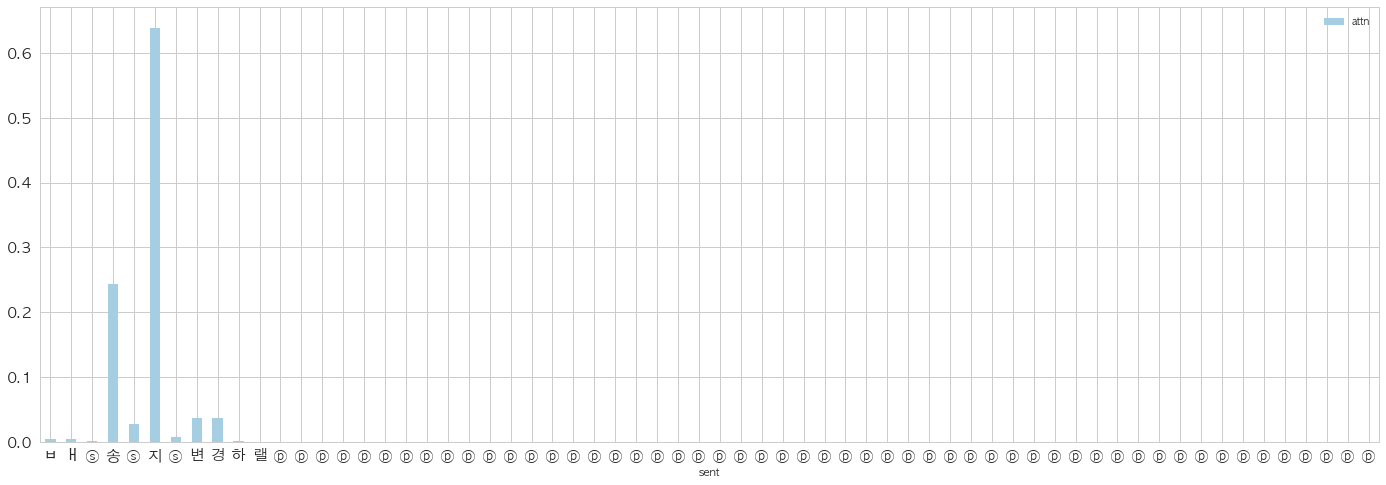

In [166]:
run_test()